In [56]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf

# Data loading

## Movie data

movie.metadata.tsv.gz [3.4 M]
Metadata for 81,741 movies, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie name
- Movie release date
- Movie box office revenue
- Movie runtime
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)

In [57]:
# Load films
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
#movies['runtime'].hist()


(81741, 9)


In [58]:
movies.head(5)

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [59]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


## Character data

character.metadata.tsv.gz [14 M]
Metadata for 450,669 characters aligned to the movies above, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:

- Wikipedia movie ID
- Freebase movie ID
- Movie release date
- Character name
- Actor date of birth
- Actor gender
- Actor height (in meters)
- Actor ethnicity (Freebase ID)
- Actor name
- Actor age at movie release
- Freebase character/actor map ID
- Freebase character ID
- Freebase actor ID

In [60]:
# Load characters
characters_header = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birthdate','actor_gender','actor_height_meters','actor_ethnicity_freebase_id','actor_name','actor_age_at_movie_release','freebase_character_actor_map_id','freebase_character_id','freebase_actor_id']
characters = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=characters_header)
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
190227,4575990,/m/0c9nrf,2007,NaN,1966-05-15,M,NaN,NaN,Josep Linuesa,40.0,/m/0gw5_6j,NaN,/m/0byw7bs
253415,33522398,/m/0cs2mqz,1934,NaN,1913-03-24,F,NaN,NaN,Diane Sinclair,20.0,/m/0hpbwxr,NaN,/m/0hpbbsc
193952,21133178,/m/05c153b,2009-11-27,NaN,NaN,F,NaN,NaN,Swathi,NaN,/m/05cjpq1,NaN,/m/0h1dlfl
95835,18302086,/m/04cqzqx,2008-06-19,NaN,NaN,M,NaN,NaN,Chil-yong Park,NaN,/m/0n4jd58,NaN,/m/0n4jd5c
205841,17998333,/m/047tw92,1939,Jasper Hawkins,1882-09-10,M,1.87,NaN,Paul Harvey,NaN,/m/0c5r1xd,/m/0c5r1xh,/m/03csbls


freebase_character_actor_map_id ?
movies are referred to by wikipedia id or freebase id
lots of data missing especially for: ethnicity, charcter name (maybe some characters aren't named in movies) , 
different date formats for release date 

## IMDB top 1000 data

This dataset includes IMDB top 1,000 movies of all time with attributes such as Title, Certificate, Duration, Genre, etc.
source: https://www.kaggle.com/datasets/omarhanyy/imdb-top-1000

- Poster_Link
- Series_Title: Title of movie
- Release_year: Movie release year
- Certificate
- Runtime [min]
- Genre
- IMDB_Rating: IMDB rating over 10
- Overview: brief summary
- Meta_score: rating by critiques
- Director
- Star 1, 2, 3, 4
- No_of_Votes: Number of votes
- Gross: Revenue in the first 5 days of release

In [61]:
imdb_top_1000 = pd.read_csv('data/imdb/imdb_top_1000.csv', thousands=',')

In [62]:
imdb_top_1000.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


## IMDB budget data:

This dataset includes the ratings for 3828 IMDB movies. 
source: https://github.com/jeremy-lee93/dsc-mod-1-project-v2-1-onl01-dtsc-pt-052620/blob/master/IMDb_budgets.csv

- Movie:  Title of movie
- Year: Movie release year
- IMDb: IMDB rating over 10
- Rating: Certificate
- Runtime [min]
- Genre
- Release Date: Movie release date
- Production Budget: Budget spent for production of the movie
- Domestic Gross: Gross revenue in US and Canada for all time
- Worldwide Gross: Worldwide gross revenue for all time

In [63]:
imdb_budget = pd.read_csv('data/imdb/IMDb_budgets.csv')

In [64]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
2423,Mommie Dearest,1981,6.7,R,129,"Biography, Drama","Sep 18, 1981",5000000,19032000,25032000
474,The Sum of All Fears,2002,6.4,PG-13,124,"Action, Drama, Thriller","May 31, 2002",68000000,118471320,193500000
3566,Brooklyn Rules,2007,6.3,R,99,"Crime, Drama","May 11, 2007",8000000,458232,458232
3683,Brahms: The Boy II,2020,4.6,PG-13,86,"Drama, Horror, Mystery","Feb 20, 2020",10000000,12611536,18976477
3590,Driving Lessons,2006,6.7,PG-13,98,"Comedy, Drama","Oct 13, 2006",4700000,239962,239962


In [65]:
imdb_budget.describe()

,Year,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross
count,3828.000000,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03
mean,2003.594044,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08
std,12.767740,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08
min,1925.000000,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00
25%,1999.000000,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07
50%,2006.000000,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07
75%,2013.000000,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08
max,2020.000000,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09


## Wikipedia

Wikipedia page views statistics
source: this data is crowed from the wikimedia API by the ./utils/extract_wikipedia_pageview_statistics.py script
    
- `name`: Title of a movie
- `date`: date in format *yyyymmddHH*
- `pageviews`: Number of page views for a movie with `name` on a `date`


In [66]:
wikipedia_pageviews = pd.read_csv('./handled_data/movies_wikipedia_pageviews.csv')

In [67]:
wikipedia_pageviews.head()

,movie_name,date,pageviews
0,Avengers: Endgame,2018042600,27
1,Avengers: Endgame,2018042700,115
2,Avengers: Endgame,2018042800,154
3,Avengers: Endgame,2018042900,141
4,Avengers: Endgame,2018043000,59


# Cleaning & Pre-processing of data

In [68]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [69]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


In [70]:
# Function to remove encoding: 
remove_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

In [71]:
movies['genres'] = movies['genres'].apply(remove_encoding)
movies['languages'] = movies['languages'].apply(remove_encoding)
movies['countries'] = movies['countries'].apply(remove_encoding)
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]


In [72]:
movies['countries'].apply(np.shape).min()

()

### Clean release dates

In [73]:
# Replace string 'release_date' column with 3 float columns ['release_year','release_month','release_day']

movies['release_date'] = movies['release_date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(movies['release_date'].str.split('-', expand=True).values, columns=['release_year','release_month','release_day']) # Split between days, months and year
movies[['release_year','release_month','release_day']] = release_date
movies = movies.drop('release_date', axis=1)


In [74]:
movies.head()

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,16
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None,None


### Remove data that is out of this world 

In [75]:
def replace_outliers_with_nan(df, col, possible_range):
    df[col] = df[col].apply(lambda x: np.nan if x < possible_range[0] or x > possible_range[1] else x)

#### Movies

In [76]:
possible_movie_runtime_range = [0, 85 * 60] # 85 hours is the Guinness World Record for the longest movie - The Cure for Insomnia

In [77]:
replace_outliers_with_nan(movies, 'runtime', possible_movie_runtime_range)

In [78]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,61286.000000
mean,1.740784e+07,4.799363e+07,93.651871
std,1.098791e+07,1.121753e+08,51.513103
min,3.300000e+02,1.000000e+04,0.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,5100.000000


In [79]:
movies[movies['runtime'] == 0]

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,NaN,0.0,[English],[United States of America],[Short Film],1894,None,None


The real length of Dickson Experimental Sound Film is 17 seconds which rounded to minutes is 0.

#### Characters

Remove age and height that are incorrect or corrupted

In [80]:
possible_age_range = (0, 150)
possible_height_range = (0, 3)

In [81]:
replace_outliers_with_nan(characters, 'actor_age_at_movie_release', possible_age_range)
replace_outliers_with_nan(characters, 'actor_height_meters', possible_height_range)

A very important characteristic describing the characters is their ethnicity. In the original dataset only the freebase id referring to the ethnicity was available. Thus, a script that can be found in `utils/ethnicities_freebase_ids_script.py` has been created to relate it to the actual labels (p.e. '/m/0152s7' stands for 'Anglo-Irish people'). A CSV has been created to map the ids and the labels, it can be found in `handled_data/ethnicities_freebase_ids.csv`. This is how it looks like:Add ethnicity labels using the freebase ethnicity ids

In [82]:
ethnicity_freebase_ids = pd.read_csv('handled_data/ethnicities_freebase_ids.csv')
ethnicity_freebase_ids.head(5)

,ethnicity_freebase_id,ethnicity_label
0,/m/01267,Albanians
1,/m/012c1l,French Canadians
2,/m/012f86,Ukrainians
3,/m/012fh,Afrikaners
4,/m/01336l,Asian Americans


As it can be seen, the ethnicities are extremely specific and it is very difficult to extract some conclusions. Therefore, we grouped all ethnicities that are repeated more than 10 times into five main ethnic groups: Asian, Black, Latino, Indian and White. This classification can be found in the CSV document in `handled_data/major_ethnicities_clustering.csv`. This is how it looks like:

In [83]:
major_ethnicities = pd.read_csv('handled_data/major_ethnicities_clustering.csv',sep=',');
major_ethnicities.head(10)

,ethnicity_label,major_ethnicity
0,African Americans,Black
1,American Jews,White
2,Americans,White
3,Argentines,Latino
4,Ashkenazi Jews,White
5,Asian Americans,Asian
6,Asian people,Asian
7,Australians,White
8,Austrians,White
9,Bengali people,Indian


Next step is to merge this two tables into the characters main dataframe

In [84]:
characters = pd.merge(characters, ethnicity_freebase_ids, how='left', left_on='actor_ethnicity_freebase_id', right_on='ethnicity_freebase_id')
characters.drop('ethnicity_freebase_id', inplace=True, axis=1)
characters = pd.merge(characters, major_ethnicities, how='left', on='ethnicity_label')

Finally, this the characters main data frame in which we are working

In [85]:
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,ethnicity_label,major_ethnicity
44132,26198830,/m/0b77ly3,1989,Cathy,1967-06-29,F,1.650,NaN,Melora Hardin,21.0,/m/0h2_d19,/m/0h2_d1c,/m/05xpms,NaN,NaN
372003,518928,/m/02kvpf,2004-03-12,Ted Milner,1960-08-16,M,1.829,NaN,Timothy Hutton,43.0,/m/06641hk,/m/0bh3h0j,/m/02t__3,NaN,NaN
184325,27367070,/m/0dgkss5,1984,NaN,1937-02-01,M,1.730,/m/0x67,Garrett Morris,46.0,/m/0dgl4z1,NaN,/m/0p_lh,African Americans,Black
126249,1799280,/m/05xyqv,1985,NaN,1941-12-31,F,1.650,NaN,Sarah Miles,43.0,/m/02tbhp3,NaN,/m/016wy9,NaN,NaN
231517,35004712,/m/03hm9k8,2013,NaN,1984-01-04,M,1.820,/m/0dryh9k,Jiiva,28.0,/m/0jx66gw,NaN,/m/0j46lfy,Indians,Indian


In [86]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.536250e+05,157666.000000,294959.000000
mean,1.393780e+07,1.747917,37.925895
std,1.079782e+07,0.106067,14.096938
min,3.300000e+02,0.610000,0.000000
25%,3.738820e+06,1.676400,28.000000
50%,1.180718e+07,1.750000,36.000000
75%,2.362455e+07,1.830000,47.000000
max,3.750192e+07,2.356000,103.000000


### IMDB

In [87]:
imdb_top_1000['Runtime'].str.contains(r'\d+ min').value_counts()

True    1000
Name: Runtime, dtype: int64

In [88]:
imdb_top_1000['Runtime'] = imdb_top_1000['Runtime'].str.extract(r'(\d+) min', expand=False).astype(int)
imdb_top_1000.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


In [89]:
imdb_top_1000.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,1000.000000,1000.000000,843.000000,1.000000e+03,8.310000e+02
mean,122.891000,7.949300,77.971530,2.736929e+05,6.803475e+07
std,28.093671,0.275491,12.376099,3.273727e+05,1.097500e+08
min,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,103.000000,7.700000,70.000000,5.552625e+04,3.253559e+06
50%,119.000000,7.900000,79.000000,1.385485e+05,2.353089e+07
75%,137.000000,8.100000,87.000000,3.741612e+05,8.075089e+07
max,321.000000,9.300000,100.000000,2.343110e+06,9.366622e+08


### Weighted IMDB rating

To estimate a movie success, we need to both account for the rating 'IMDB_Rating' and to the correponding number of votes 'No_of_Votes'. To do so, we build a new weighted rating based on a shrinkage estimator: 

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 

where:

R = average for the movie (mean) = (Rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed (currently 25088)

C = the mean vote across the whole report (currently 7.94)

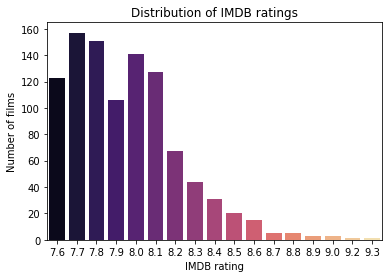

In [90]:
sns.countplot(x='IMDB_Rating', data = imdb_top_1000, palette="magma").set(title='Distribution of IMDB ratings',xlabel='IMDB rating', ylabel='Number of films');


In [91]:
C = imdb_top_1000['IMDB_Rating'].mean()
m = imdb_top_1000['No_of_Votes'].min()
v = imdb_top_1000['No_of_Votes']
R = imdb_top_1000['IMDB_Rating']

In [92]:
imdb_top_1000['WR'] = (v / (v + m)) * R + (m / (v + m)) * C # Complete original dataset


To check if the weighted rating has worked, we display below the best rated movie. We observe that for an IMDB rating of 9/10, the weighted rating WR is better for movies with the most votes. We conclude that this weighted rating is more representative of a movie' success.

In [93]:
imdb_top_1000[['Series_Title','IMDB_Rating','WR','No_of_Votes']].sort_values('WR', ascending=False).head()

,Series_Title,IMDB_Rating,WR,No_of_Votes
0,The Shawshank Redemption,9.3,9.285691,2343110
1,The Godfather,9.2,9.180931,1620367
2,The Dark Knight,9.0,8.988679,2303232
3,The Godfather: Part II,9.0,8.977178,1129952
4,12 Angry Men,9.0,8.963129,689845


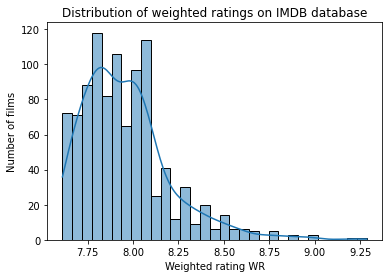

In [94]:
sns.histplot(x='WR', data = imdb_top_1000, kde=True).set(title='Distribution of weighted ratings on IMDB database',xlabel='Weighted rating WR', ylabel='Number of films');


### Merge IMDB database with movie database to have common features

We would like to merge the data from CMU movies and IMDB top 1000. Since we don't want to reduce the size of data, we would rather to an outer merge and fill missing values with NaN.

In [95]:
len((imdb_top_1000['Series_Title'] + imdb_top_1000['Released_Year'].astype(str)).unique()) / len(imdb_top_1000)

1.0

In [96]:
# Remove duplicated movie with video game
movies.drop(movies[movies['wikipedia_id'] == 3184269].index, inplace=True)
# Fix duplicated movie with changing it release year to the correct one based on its wikipedia page
movies.loc[movies['wikipedia_id'] == 25357930, ['release_year']] = "2010"

In [97]:
imdb_top_1000.rename({'Series_Title': 'name', 'Released_Year': 'release_year'}, axis=1, inplace=True)

In [98]:
imdb_top_1000.loc[imdb_top_1000['name'] == 'Apollo 13', 'release_year'] = '1995' # The release year was wrong in the dataset change from PG to 1995 /year was obtained from wikipedia/
movies['release_year'] = movies['release_year'].replace('nan', np.nan).astype('float').astype('Int16')
movies['release_month'] = movies['release_month'].replace('nan', np.nan).astype('float').astype('Int16')
movies['release_day'] = movies['release_day'].replace('nan', np.nan).astype('float').astype('Int16')
imdb_top_1000['release_year'] = imdb_top_1000['release_year'].replace('nan', np.nan).astype('float').astype('Int16')


In [99]:
movie_feature = imdb_top_1000.merge(movies, on=['name', 'release_year'], how='outer')


In [100]:
def fill_NaN(df, column_left, column_right, column_name=None): # Updates missing data from left column with right column data
    if column_name is None:
        column_name = column_left
    df[column_name] = df[column_left].fillna(df[column_right])

In [101]:
movie_feature['Genre'] = movie_feature['Genre'].replace(np.nan, '').apply(lambda x: x.split(', '))

fill_NaN(movie_feature,'runtime','Runtime')
fill_NaN(movie_feature,'genres','Genre')
movie_feature.drop(labels=['Runtime','Genre'], axis=1, inplace=True)

In [102]:
movie_feature.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres',
       'release_month', 'release_day'],
      dtype='object')

In [103]:
movie_feature.sample(3)

,Poster_Link,name,release_year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,...,WR,wikipedia_id,freebase_id,box_office_revenue,runtime,languages,countries,genres,release_month,release_day
7493,NaN,Mera Saathi,1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,36027636.0,/m/0h703rh,NaN,NaN,[Hindi],[India],[Drama],<NA>,<NA>
39989,NaN,"The 3,000 Mile Chase",1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,27617747.0,/m/0c422wp,NaN,100.0,[English],[United States of America],"[Action, Drama]",<NA>,<NA>
75791,NaN,Blood Brothers,1973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10931140.0,/m/02qvbt0,NaN,86.0,"[Chinese, Standard Mandarin]",[Hong Kong],"[Martial Arts Film, Drama, Chinese Movies]",2,24


In [104]:
movie_feature.describe()

,release_year,IMDB_Rating,Meta_score,No_of_Votes,Gross,WR,wikipedia_id,box_office_revenue,runtime,release_month,release_day
count,75235.0,1000.000000,843.000000,1.000000e+03,8.310000e+02,1000.000000,8.174000e+04,8.401000e+03,61695.000000,42666.0,39372.0
mean,1977.602419,7.949300,77.971530,2.736929e+05,6.803475e+07,7.957808,1.740801e+07,4.799363e+07,93.842314,6.692495,15.651656
std,29.11519,0.275491,12.376099,3.273727e+05,1.097500e+08,0.242824,1.098786e+07,1.121753e+08,51.436090,3.483249,8.715623
min,1010.0,7.600000,28.000000,2.508800e+04,1.305000e+03,7.611562,3.300000e+02,1.000000e+04,0.000000,1.0,1.0
25%,1956.0,7.700000,70.000000,5.552625e+04,3.253559e+06,7.799293,7.323722e+06,2.083193e+06,81.000000,4.0,8.0
50%,1985.0,7.900000,79.000000,1.385485e+05,2.353089e+07,7.913042,1.777899e+07,1.063969e+07,93.000000,7.0,16.0
75%,2004.0,8.100000,87.000000,3.741612e+05,8.075089e+07,8.077983,2.715589e+07,4.071696e+07,107.000000,10.0,23.0
max,2020.0,9.300000,100.000000,2.343110e+06,9.366622e+08,9.285691,3.750192e+07,2.782275e+09,5100.000000,12.0,31.0


In [105]:
print(f'There are {(imdb_top_1000.shape[0]+movies.shape[0]) - movie_feature.shape[0]} common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes {imdb_top_1000.shape[0]} elements and Movie corpus includes {movies.shape[0]}.')


There are 603 common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes 1000 elements and Movie corpus includes 81740.


In [106]:
movie_feature.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres',
       'release_month', 'release_day'],
      dtype='object')

[Text(0.5, 1.0, 'Distribution of weighted ratings on merged database'),
 Text(0.5, 0, 'Weighted rating WR'),
 Text(0, 0.5, 'Number of films')]

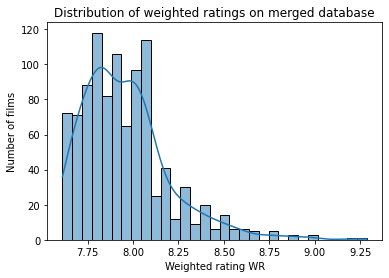

In [107]:
sns.histplot(x='WR', data=movie_feature, kde=True).set(title='Distribution of weighted ratings on merged database',xlabel='Weighted rating WR', ylabel='Number of films')


In [108]:
len((movie_feature['name'] + movie_feature['release_year'].astype(str)).unique()) / len(movie_feature)

0.9977476654857129

### Fill missing budget data from imdb budget dataset

In [109]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
1533,Step Up 3D,2010,6.2,PG-13,107,"Drama, Music, Romance","Aug 6, 2010",30000000,42400223,165889117
1916,Milk,2008,7.5,R,128,"Biography, Drama","Nov 26, 2008",20000000,31841299,57293371
1805,Cradle 2 the Grave,2003,5.8,R,101,"Action, Crime, Drama","Feb 28, 2003",25000000,34657731,56434942
14,Avengers: Age of Ultron,2015,7.3,PG-13,141,"Action, Adventure, Sci-Fi","Apr 22, 2015",365000000,459005868,1396099202
3683,Brahms: The Boy II,2020,4.6,PG-13,86,"Drama, Horror, Mystery","Feb 20, 2020",10000000,12611536,18976477


In [110]:
imdb_budget['Release Date'] = imdb_budget['Release Date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(pd.to_datetime(imdb_budget['Release Date']).apply(lambda x: [x.year, x.month, x.day]).tolist(), columns=['release_year','release_month','release_day'])
imdb_budget[['release_year','release_month','release_day']] = release_date

In [111]:
imdb_budget['release_year'] = imdb_budget['release_year'].astype('Int16')
imdb_budget['release_month'] = imdb_budget['release_month'].astype('Int16')
imdb_budget['release_day'] = imdb_budget['release_day'].astype('Int16')

In [112]:
imdb_budget.drop(['Year', 'Release Date'], axis=1, inplace=True)
imdb_budget.rename({'Movie': 'name', 'Genre': 'genres'}, axis=1, inplace=True)
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [113]:
imdb_budget.describe()

,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross,release_year,release_month,release_day
count,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03,3828.0,3828.0,3828.0
mean,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08,2003.594044,7.3221,15.891066
std,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08,12.76774,3.378479,8.437532
min,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00,1925.0,1.0,1.0
25%,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07,1999.0,5.0,9.0
50%,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07,2006.0,8.0,16.0
75%,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08,2013.0,10.0,23.0
max,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09,2020.0,12.0,31.0


In [114]:
len((movie_feature['name'] + str(movie_feature['release_year'])).unique()) / len(movie_feature)

0.9232380047968638

In [115]:
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [116]:
movie_feature.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres',
       'release_month', 'release_day'],
      dtype='object')

In [117]:
movie_feature_with_budget = movie_feature.merge(imdb_budget, on=['name', 'release_year'], how='outer')

In [118]:
movie_feature_with_budget.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres_x',
       'release_month_x', 'release_day_x', 'IMDb', 'Rating', 'Runtime',
       'genres_y', 'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y'],
      dtype='object')

In [119]:
fill_NaN(movie_feature_with_budget,'genres_x','genres_y','genre')
fill_NaN(movie_feature_with_budget,'release_day_x','release_day_y','release_day')
fill_NaN(movie_feature_with_budget,'release_month_x','release_month_y','release_month')
fill_NaN(movie_feature_with_budget,'Certificate','Rating')
fill_NaN(movie_feature_with_budget,'runtime','Runtime')
fill_NaN(movie_feature_with_budget,'IMDB_Rating','IMDb')

### Investigate the gross difference between the original and the imdb budget datasets

<AxesSubplot:title={'center':'Distribution of the difference of the total worldwide gross data from the two datasets'}, ylabel='Frequency'>

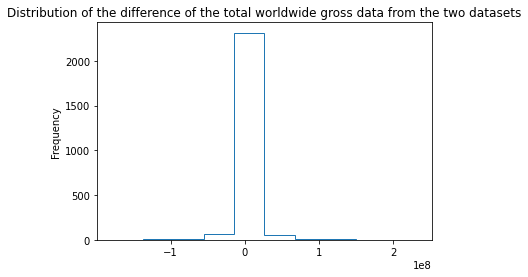

In [120]:
(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']).plot(kind='hist', histtype='step', title='Distribution of the difference of the total worldwide gross data from the two datasets')

<AxesSubplot:title={'center':'Distribution of the percentage in difference of the total worldwide gross data from the two datasets'}, ylabel='Frequency'>

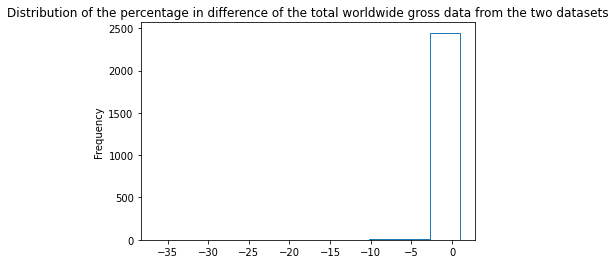

In [121]:
((movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']) / movie_feature_with_budget['box_office_revenue']).plot(kind='hist', histtype='step', title='Distribution of the percentage in difference of the total worldwide gross data from the two datasets')

In [122]:
movie_feature_with_budget_differences = movie_feature_with_budget.copy()
movie_feature_with_budget_differences['gross_difference'] = np.abs(movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'])
movie_feature_with_budget_differences['gross_difference%'] = ((np.abs(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']) / movie_feature_with_budget['box_office_revenue']) * 100).round(2)

In [123]:
# Difference between the total worldwide gross data from the two datasets
movie_feature_with_budget_differences \
    [(movie_feature_with_budget_differences['gross_difference'] != 0) & (~movie_feature_with_budget_differences['gross_difference'].isna())] \
    .sort_values('gross_difference%', ascending=False) \
    [['name', 'box_office_revenue', 'Worldwide Gross', 'gross_difference', 'gross_difference%']]

,name,box_office_revenue,Worldwide Gross,gross_difference,gross_difference%
2614,The Son of No One,30680.0,1148578.0,1117898.0,3643.74
11355,Restless,163265.0,2772511.0,2609246.0,1598.17
4303,Welcome to Collinwood,336620.0,4606284.0,4269664.0,1268.39
31033,Margaret,46495.0,623292.0,576797.0,1240.56
458,The Wizard of Oz,3017000.0,34949482.0,31932482.0,1058.42
...,...,...,...,...,...
16293,Mrs. Doubtfire,441286195.0,441286003.0,192.0,0.00
795,Ocean's Eleven,450717150.0,450728529.0,11379.0,0.00
78873,The Dead Zone,20766616.0,20766000.0,616.0,0.00
5526,Failure to Launch,128406887.0,128402901.0,3986.0,0.00


In [124]:
# Percentage differences between the gross data from the two datasets
movie_feature_with_budget_differences.describe(percentiles=[.25, .5, .75, .8, .9, .95])[['gross_difference%']]

,gross_difference%
count,2468.000000
mean,16.436353
std,101.362374
min,0.000000
25%,0.020000
50%,0.695000
75%,5.455000
80%,9.888000
90%,34.123000
95%,62.818000


In [125]:
movie_feature_with_budget_differences[movie_feature_with_budget_differences['gross_difference'] == 0].shape[0] / movie_feature_with_budget_differences['gross_difference%'].notna().sum()

0.15842787682333873

In [126]:
movie_feature_with_budget_differences[
    (movie_feature_with_budget_differences['name'] == 'The Son of No One') |
    (movie_feature_with_budget_differences['name'] == 'Restless') |
    (movie_feature_with_budget_differences['name'] == 'Welcome to Collinwood')
][[
    'name', 'box_office_revenue', 'Worldwide Gross'
]]

,name,box_office_revenue,Worldwide Gross
2614,The Son of No One,30680.0,1148578.0
4303,Welcome to Collinwood,336620.0,4606284.0
11355,Restless,163265.0,2772511.0
19658,Restless,NaN,NaN
32477,Restless,NaN,NaN


In [127]:
# gross_difference = box_office_revenue - Worldwide Gross
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] > 0).sum())
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] < 0).sum())
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] == 0).sum())
(movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross']).describe()

1012
1065
391


count    2.468000e+03
mean     4.134445e+05
std      1.569719e+07
min     -1.785914e+08
25%     -6.153875e+05
50%      0.000000e+00
75%      1.989842e+05
max      2.310745e+08
dtype: float64

We want to fill the missing data from the imdb budget dataset. For this purpose we are comparing the difference between the CMU, imdb top 1000, and imdb budget data. We have the:
 
 * `box_office_revenue` - from CMU with 8401 values /total gross/
 * `Gross` - from imdb top 1000 with 831 values /total gross in US and Canada/
 * `Domestic Gross` - from imdb budget with 3841 values /total gross in US and Canada/
 * `Worldwide Gross` - from imdb budget with 3841 values /total gross/

We would only consider the total worldwide gross since we are investigating movies from the whole world. The information for it is contained in the `box_office_revenue` and `Worldwide Gross`. Only around 20% of the values for the total gross are the same. Also, we know that the other data in `box_office_revenue` is not bigger or smaller than the `Worldwide Gross` for all records. So we can conclude that `box_office_revenue` and `Worldwide Gross` are not connected.

Based on this, we cannot combine the data from the both datasets and we would prefer using the data from the imdb budget dataset because it contains information about the budget of the movie and the data inside seams more accurate based on the comparison of a subset of it with Wikipedia data.

In [128]:
movie_feature_with_budget.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres_x',
       'release_month_x', 'release_day_x', 'IMDb', 'Rating', 'Runtime',
       'genres_y', 'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y', 'genre', 'release_day',
       'release_month'],
      dtype='object')

In [129]:
# Remove merged extra columns 
movie_feature_with_budget.drop(['box_office_revenue','Domestic Gross','Gross','Rating',
                                'Runtime','IMDb','release_month_x','release_month_y','release_day_x',
                                'release_day_y','genres_x','genres_y'], axis=1, inplace=True)

# Rename gross column
movie_feature_with_budget.rename({'Worldwide Gross': 'total_gross'}, axis=1, inplace=True)

# Remove data that won't be used in the analysis
movie_feature_with_budget.drop(['Poster_Link'], axis=1, inplace=True) 

# Compute profit as success indicator
movie_feature_with_budget['profit'] = movie_feature_with_budget['total_gross'] - movie_feature_with_budget['Production Budget']

In [130]:
movie_feature_with_budget.columns

Index(['name', 'release_year', 'Certificate', 'IMDB_Rating', 'Overview',
       'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4',
       'No_of_Votes', 'WR', 'wikipedia_id', 'freebase_id', 'runtime',
       'languages', 'countries', 'Production Budget', 'total_gross', 'genre',
       'release_day', 'release_month', 'profit'],
      dtype='object')

In [131]:
movie_feature_with_budget.describe()

,release_year,IMDB_Rating,Meta_score,No_of_Votes,WR,wikipedia_id,runtime,Production Budget,total_gross,release_day,release_month,profit
count,76183.0,4399.000000,843.000000,1.000000e+03,1000.000000,8.174000e+04,62713.000000,3.841000e+03,3.841000e+03,40599.0,43858.0,3.841000e+03
mean,1978.05941,6.648011,77.971530,2.736929e+05,7.957808,1.740801e+07,94.079673,4.028301e+07,1.205057e+08,15.658834,6.707875,8.022274e+07
std,29.227715,1.058971,12.376099,3.273727e+05,0.242824,1.098786e+07,51.095357,4.475082e+07,1.991119e+08,8.708488,3.483286,1.694921e+08
min,1010.0,1.500000,28.000000,2.508800e+04,7.611562,3.300000e+02,0.000000,7.000000e+03,0.000000e+00,1.0,1.0,-1.580898e+08
25%,1956.0,6.000000,70.000000,5.552625e+04,7.799293,7.323722e+06,82.000000,1.100000e+07,1.686693e+07,8.0,4.0,-3.452140e+05
50%,1986.0,6.700000,79.000000,1.385485e+05,7.913042,1.777899e+07,93.000000,2.500000e+07,5.071937e+07,16.0,7.0,2.289719e+07
75%,2004.0,7.500000,87.000000,3.741612e+05,8.077983,2.715589e+07,107.000000,5.000000e+07,1.379848e+08,23.0,10.0,8.861348e+07
max,2020.0,9.300000,100.000000,2.343110e+06,9.285691,3.750192e+07,5100.000000,4.000000e+08,2.797801e+09,31.0,12.0,2.551701e+09


In [132]:
movie_feature_with_budget.sample(5)

,name,release_year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,...,freebase_id,runtime,languages,countries,Production Budget,total_gross,genre,release_day,release_month,profit
8959,Long Dark Night,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/m/04f3gv4,200.0,"[Croatian, Serbian]",[Croatia],NaN,NaN,"[Drama, War film]",7,3,NaN
39435,Weird Girl,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/m/0dg_mr,6.0,[English],NaN,NaN,NaN,"[Short Film, Animation]",19,9,NaN
71431,Onnanu nammal,1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/m/04jlvgq,NaN,[Malayalam],[India],NaN,NaN,"[Romance Film, Drama, Comedy film]",<NA>,<NA>,NaN
18853,Battle Planet,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/m/058c10r,85.0,[English],[United States of America],NaN,NaN,[Science Fiction],2,11,NaN
59707,Crayon Shin-chan: The Storm Called: Operation ...,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/m/0h981bw,107.0,NaN,NaN,NaN,NaN,"[Anime, Animation]",16,4,NaN


## Account for inflation: 

As our movie database has movies dating back to 1921, we need to adjust the budgets and profits through an inflation rate.

Source: https://inflationdata.com/Inflation/Inflation/DecadeInflation.asp

In [133]:
# Create dictionary of cumulative inflation rate per decade since 1913 in the US:
inflation_rates = [92.86, 4.82, -18.6, 68.57, 24.58, 28.23, 103.45, 64.41, 33.47, 28.31, 19.38, 1.27]
inflation_rates = [x / 100 + 1 for x in inflation_rates]
decades = list(np.linspace(1913,2023,len(inflation_rates)))
inflation_dic = dict(map(lambda i,j : (i,j) , decades, inflation_rates))

In [134]:
df = movie_feature_with_budget.copy()

In [135]:
# Initialisation
df['profit_modified'] = df['profit']
df['total_gross_modified'] = df['total_gross']
df['budget_modified'] = df['Production Budget']

In [136]:
for k in range(len(decades)-1): # For each decade
    year_before = decades[k]
    year = decades[k+1]
    inflation_rate = inflation_dic[year_before]
    
    decade_df = df[(df['release_year']<year) & (df['release_year']>year_before)] # decade mask
    
    idx = decade_df.index.tolist()

    # Create new column with prices modified by interest rate
    df.loc[idx, 'profit_modified'] = decade_df['profit'] * inflation_rate
    df.loc[idx, 'total_gross_modified'] = decade_df['total_gross'] * inflation_rate
    df.loc[idx, 'budget_modified'] = decade_df['Production Budget'] * inflation_rate

In [137]:
movie_feature_with_budget = df.copy()

In [138]:
movie_feature_with_budget.head(2)

,name,release_year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,...,languages,countries,Production Budget,total_gross,genre,release_day,release_month,profit,profit_modified,total_gross_modified
0,The Shawshank Redemption,1994,A,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,...,[English],[United States of America],25000000.0,28417060.0,"[Crime Fiction, Buddy film, Prison film, Drama...",10,9,3417060.0,4.560750e+06,3.792825e+07
1,The Godfather,1972,A,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,...,"[Latin, Italian, Sicilian, English]",[United States of America],7000000.0,268500000.0,"[Crime Fiction, Gangster Film, Crime Drama, Fa...",15,3,261500000.0,3.353214e+08,3.442976e+08


In [139]:
# Delete the columns for budget which are not modified by inflation rate: 
movie_feature_with_budget.drop(['total_gross','profit', 'Production Budget'], axis=1, inplace=True)

### Wikipedia pageviews

In [140]:
wikipedia_pageviews['date'] = pd.to_datetime(wikipedia_pageviews['date'], format='%Y%m%d%H')

In [141]:
wikipedia_pageviews.sample(5)

,movie_name,date,pageviews
405177,Back to the Future,2015-09-16,4125
114577,Zootopia,2022-04-20,2496
335246,The Lost World: Jurassic Park,2019-06-16,2099
570725,Madagascar: Escape 2 Africa,2017-12-09,592
108015,American Sniper,2019-02-03,3516


In [142]:
wikipedia_pageviews.describe()

,pageviews
count,2.301748e+06
mean,1.688527e+03
std,6.576590e+03
min,0.000000e+00
25%,1.170000e+02
50%,8.810000e+02
75%,1.891000e+03
max,1.982874e+06


In [143]:
wikipedia_pageviews.rename({'movie_name': 'name'}, axis=1, inplace=True)

In [144]:
wikipedia_pageviews_mean_per_day = wikipedia_pageviews.groupby('name').mean()
movie_feature_with_budget_and_wikipedia_pageviews = pd.merge(movie_feature_with_budget, wikipedia_pageviews_mean_per_day, on='name', how='left')

C:\Users\34683\AppData\Local\Temp/ipykernel_25696/1925052420.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  wikipedia_pageviews_mean_per_day = wikipedia_pageviews.groupby('name').mean()


In [145]:
movie_feature_with_budget_and_wikipedia_pageviews.describe()

,release_year,IMDB_Rating,Meta_score,No_of_Votes,WR,wikipedia_id,runtime,Production Budget,release_day,release_month,profit_modified,total_gross_modified,pageviews
count,76183.0,4399.000000,843.000000,1.000000e+03,1000.000000,8.174000e+04,62713.000000,3.841000e+03,40599.0,43858.0,3.841000e+03,3.841000e+03,1198.000000
mean,1978.05941,6.648011,77.971530,2.736929e+05,7.957808,1.740801e+07,94.079673,4.028301e+07,15.658834,6.707875,1.020213e+08,1.529179e+08,1629.608527
std,29.227715,1.058971,12.376099,3.273727e+05,0.242824,1.098786e+07,51.095357,4.475082e+07,8.708488,3.483286,2.116340e+08,2.471666e+08,2306.323344
min,1010.0,1.500000,28.000000,2.508800e+04,7.611562,3.300000e+02,0.000000,7.000000e+03,1.0,1.0,-1.887276e+08,0.000000e+00,0.833333
25%,1956.0,6.000000,70.000000,5.552625e+04,7.799293,7.323722e+06,82.000000,1.100000e+07,8.0,4.0,-4.548600e+05,2.182930e+07,96.998887
50%,1986.0,6.700000,79.000000,1.385485e+05,7.913042,1.777899e+07,93.000000,2.500000e+07,16.0,7.0,3.032431e+07,6.537242e+07,963.526160
75%,2004.0,7.500000,87.000000,3.741612e+05,8.077983,2.715589e+07,107.000000,5.000000e+07,23.0,10.0,1.134429e+08,1.742373e+08,2170.703618
max,2020.0,9.300000,100.000000,2.343110e+06,9.285691,3.750192e+07,5100.000000,4.000000e+08,31.0,12.0,3.274088e+09,3.578183e+09,37415.568125


In [146]:
# For simplicity of use, we rename the dataframe
df_all = movie_feature_with_budget_and_wikipedia_pageviews

For the final dataset obtained, we gather data from 4 different sources. In order to not restrain ourselves to only common features and end up with a smaller dataset, we made the choice of outer merges filled with NaN. Indeed, if we had taken inner merge of all datasets, it might be that our final dataset is both small and not badly representative of the population. 

Having NaN values has however some consequences on our data analysis. It might be that the NaN are not fully random, for instance, runtime for Crime movies are all missing values while we have the runtime for all Comedies. This should ideally be investigated further to check the NaN are indeed random. In the framework of this milestone, the choice was to focus on other tasks. We will thus assume randomness of NaN values.



# Exploratory Data Analysis

## Success indicators

Success of a movie can be very subjective. We thus need to diversify our definitions of success to have a holistic view of our dataset. The following success indicators are considered: 
- How well a movie is received: 
    IMDB ratings which should be weighted by the number of votes
- How profitable a movie is: 
    Overall gross revenue of the movie OR profit = gross revenue - budget spent
- How long a movie will last in time: 
    Number of connection to the movie wikipedia page


## Explore data

Looking at the impacts of features on eachother by drawing a correlation heatmap

C:\Users\34683\AppData\Local\Temp/ipykernel_25696/2314911968.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


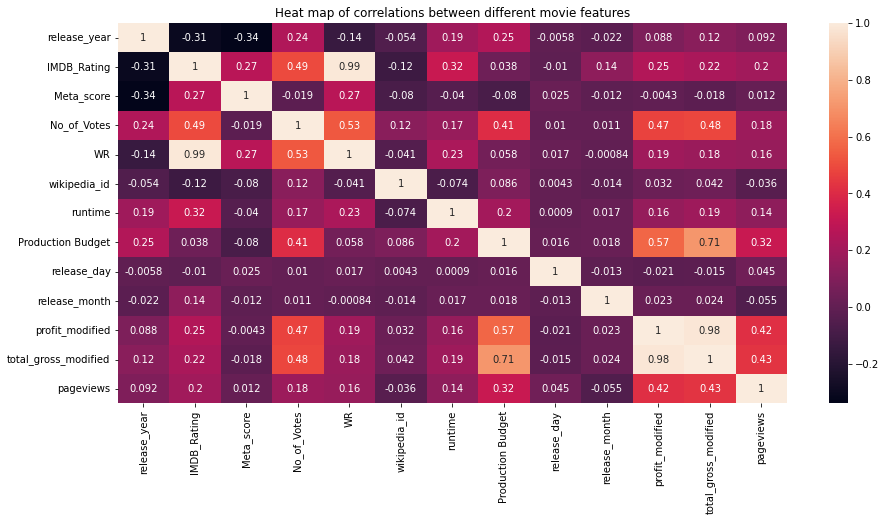

In [147]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


### ADD comment on correlation results !!!

### Impact of release date on success

To assess the impact of release date on success, we need to use the information on 'release_month' for each movie and need to choose a feature for success which can be either the IMDB weighted rating 'WR' or the 'box_office_revenue'. Since 'WR' and 'release_month' are features coming from two different datasets, we need to use the merged dataframe movie_feature which contains only 875. We can then compare the results found with ('WR','release_month') to ('box_office_revenue','release_month') which is based on much more data: 81741. 

-> CAREFUL, WHY ARE RATINGS AND GROSS REVENUE COMPLETELY UNCORRELATED ? 

In [148]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the release month information for {df_all['release_month'].count()} movies which is a big enough dataset to be representative.")

Out of 83085 movies in out dataset, we have the release month information for 43858 movies which is a big enough dataset to be representative.


In [149]:
df_release = df_all.dropna(how='all', subset=['release_month']) # Remove NaN months

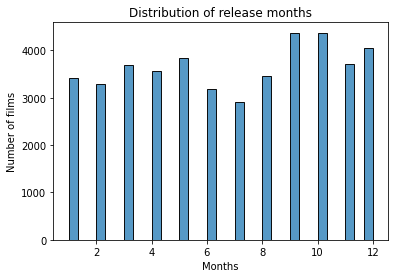

In [150]:
sns.histplot(x='release_month', data = df_release).set(title='Distribution of release months',xlabel='Months', ylabel='Number of films');

From the plot above, we can see that the distribution of release months is fairly homogeneous accross the data which allows to investigate success accross different release months.

In [151]:
df_release=df_release.sort_values(by='release_month', ascending=True)

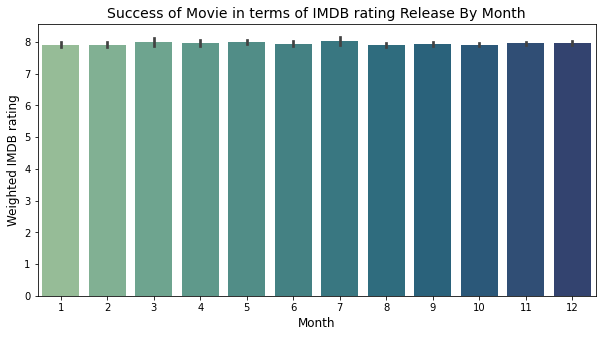

In [152]:
# Plot
plt.figure(figsize=(10,5));
ax = sns.barplot(x="release_month", y="WR",data=df_release,palette='crest');
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weighted IMDB rating', fontsize=12)
plt.title('Success of Movie in terms of IMDB rating Release By Month', fontsize=14);

Text(0.5, 1.0, 'Success in terms of revenue of Movie Release By Month')

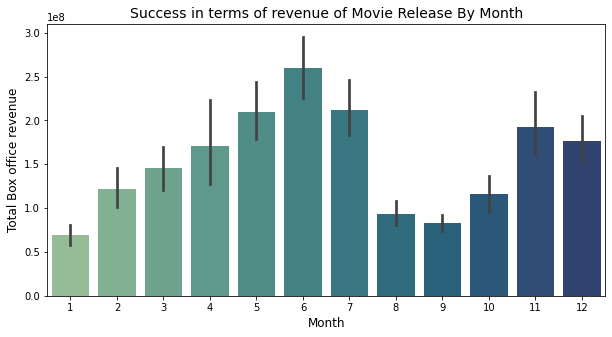

In [153]:
# Plot
plt.figure(figsize=(10,5))
ax = sns.barplot(x="release_month", y="total_gross_modified",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Box office revenue', fontsize=12)
plt.title('Success in terms of revenue of Movie Release By Month', fontsize=14)

UPDATE:


As we can see from the results above, the movie weighted ratings are not at all influenced by the release period. However, the gross revenue is. In particular, if we look at the release gross revenue in the 5 days following release, we see that movies released in summer and in the end of the year are more successful. This follows the same trend as the total gross revenue meaning that this difference in success across months is probably due to the cinema revenue in the first 5 days. Since the distribution of movies is fairly the same across our dataset, we can deduce that these periods are more favourable for movie release. This result coincides with usual holidays periods where people have more time to go to the cinema. 

## What budget should be spent on a successful movie?

To see what budget should be spent on a successful movie, we want to compare mainly three features, the budget spent 'Production Budget', the profit made 'profit' and the weighted rating of the movie to account for successfulness 'WR'.


In [154]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the profit information for {df_all['profit_modified'].count()} movies, total gross revenue information for {df_all['total_gross_modified'].count()} movies , budget information for {df_all['Production Budget'].count()} movies.")

Out of 83085 movies in out dataset, we have the profit information for 3841 movies, total gross revenue information for 3841 movies , budget information for 3841 movies.


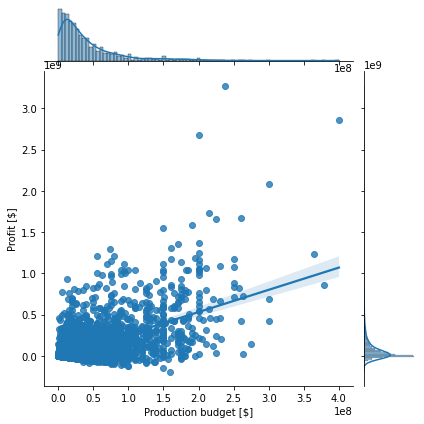

In [155]:
h = sns.jointplot(data=df_all, x='Production Budget', y='profit_modified', kind="reg");
h.ax_joint.set_xlabel('Production budget [$]');
h.ax_joint.set_ylabel('Profit [$]');

As we can see from the plot above, the positive trend line indicates that an increase in the budget will result in an increase in profit. However, there seems to be a lot of outliers. For our datastory (Milestone 3), it would be interesting to split this into two categories, high budget movies and average movies. Additionnaly, we will want to investigate if this budget trend is different across genres.

To compare the link between all three features, we build the pairplot below:

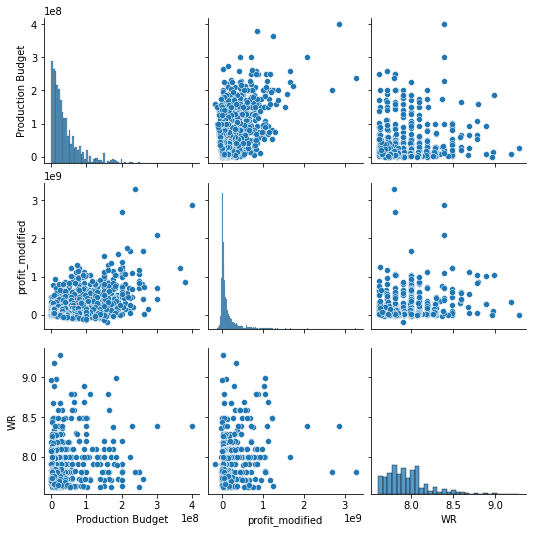

In [156]:
sns.pairplot(movie_feature_with_budget[['Production Budget','profit_modified','WR']]);

### Top 20 most profitable movies

In [157]:
Top20_ProfitableMovies = df_all.sort_values('profit_modified', ascending=False).head(20)

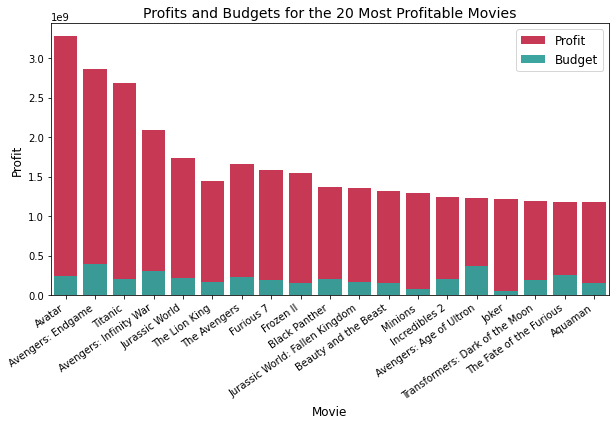

In [158]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['Production Budget'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Profits and Budgets for the 20 Most Profitable Movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

### Top lasting movies

### ---->TO COMPLETE MY MEHDI  with wikipedia connection

## Impact of director

In [159]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the director information for {df_all['Director'].count()} movies coming from the top 1000 IMDB data set.")

Out of 83085 movies in out dataset, we have the director information for 1000 movies coming from the top 1000 IMDB data set.


In [160]:
df_director = df_all.dropna(how='all', subset=['Director']) # Remove NaN directors

In [161]:
Top20_ProfitableMovies = df_director.sort_values('profit_modified', ascending=False).head(20)

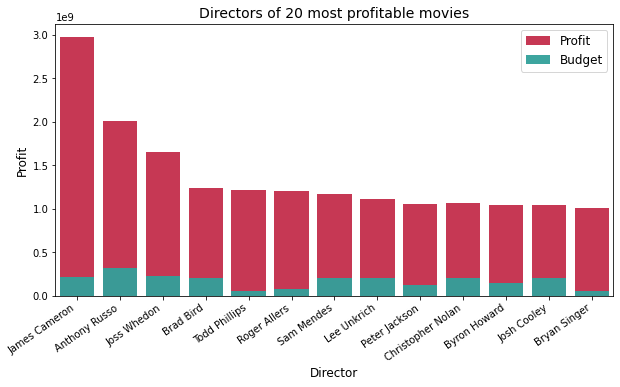

In [162]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['Director'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Director'],y=Top20_ProfitableMovies['Production Budget'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Director', fontsize=12)
plt.title("Directors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

In [163]:
Top20_ProfitableMovies['Director']

623        James Cameron
59         Anthony Russo
652        James Cameron
60         Anthony Russo
357          Joss Whedon
891            Brad Bird
33         Todd Phillips
43          Roger Allers
751           Sam Mendes
151          Lee Unkrich
13         Peter Jackson
63     Christopher Nolan
583        Anthony Russo
618        Peter Jackson
2      Christopher Nolan
330         Byron Howard
596          Josh Cooley
10         Peter Jackson
5          Peter Jackson
342         Bryan Singer
Name: Director, dtype: object

## Impact of actors TO COMPLETE BY PAU

In [164]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the 1st actor information for {df_all['Star1'].count()} movies coming from the top 1000 IMDB data set.")

Out of 83085 movies in out dataset, we have the 1st actor information for 1000 movies coming from the top 1000 IMDB data set.


For now, we only consider the main actor of a movie but this can be extrapolated to all actors accross multiple movies for our next milestone. 

In [165]:
df_main_actor = df_all.dropna(how='all', subset=['Star1']) # Remove NaN actors

In [166]:
Top20_ProfitableMovies = df_main_actor.sort_values('profit_modified', ascending=False).head(20)

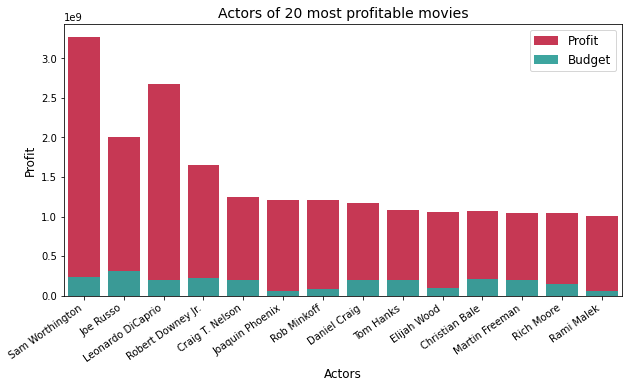

In [167]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['Production Budget'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Actors', fontsize=12)
plt.title("Actors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

For our datastory, the goal would be to cluster actors accross genres. That way, we can forecast which actor would be best to select for a particular genre to boost success.

## Popular features in characters

The characters table is splitted between actors and actresses to study each gender as a whole different group.

In [168]:
characters_male = characters[characters['actor_gender'] == 'M']
characters_female = characters[characters['actor_gender'] == 'F']

The following plot presents the height distribution for the actors and actresses. We can see that men tend to be taller than women actors. Also, it can be seen that in the dataset there are way more men than women

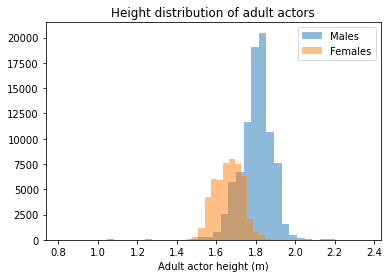

In [169]:
def filter_children(characters):
    LIMIT_CHILDREN_AGE = 14
    return characters[(characters['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]

def characters_height_histogram(characters, bins):
    characters_height = characters.dropna(subset=['actor_height_meters'])
    plt.hist(characters_height['actor_height_meters'],bins=bins, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Adult actor height (m)')
    plt.title('Height distribution of adult actors')

characters_height_histogram(filter_children(characters_male), bins=40)
characters_height_histogram(filter_children(characters_female), bins=25)


Another important characteristic we can study is the age on movie release. Again, there is a huge difference between women and men. Women play roles when they are younger, while men seem to have longer careers.

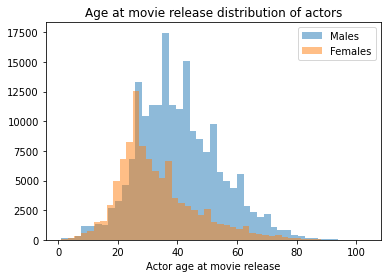

In [170]:
def characters_age_histogram(characters):
    characters_age = characters.dropna(subset=['actor_age_at_movie_release']).sort_values(by=['actor_age_at_movie_release'])
    characters_age = characters_age[characters_age['actor_age_at_movie_release'] > 0]
    plt.hist(characters_age['actor_age_at_movie_release'], bins=45, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Actor age at movie release')
    plt.title('Age at movie release distribution of actors')

characters_age_histogram(characters_male)
characters_age_histogram(characters_female)

The following plot shows the ethnicity distribution for actors and actresses of the dataset. It can be seen how white people clearly dominate the characters dataset by more than a half of it. Indians are also a big group representing 1/4 of the ethnicities. In this case, the difference between genders is not that big.

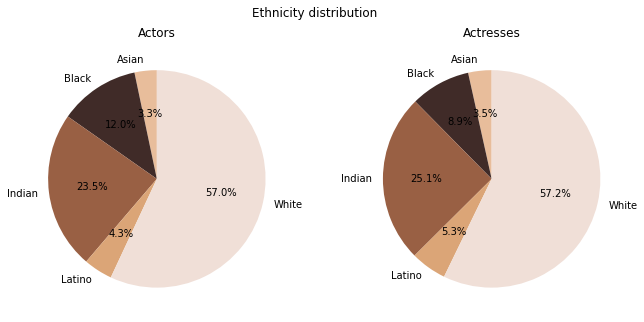

In [171]:
def pie_chart_actor_ethnicities(actors, title, ax):
    actors_ethnicity = actors.dropna(subset=['major_ethnicity'])
    actors_ethnicity = actors_ethnicity[actors_ethnicity['major_ethnicity'] != 'unknown']
    ethnicities, counts = np.unique(actors_ethnicity['major_ethnicity'], return_counts=True)
    #print(np.sort(counts))
    others_count = 0
    plot_ethnicities = []
    plot_counts = []
    ETHNICITY_THRESHOLD = 1
    for ethnicity, count in zip(ethnicities, counts):
        if count > ETHNICITY_THRESHOLD:
            plot_ethnicities.append(ethnicity)
            plot_counts.append(count)
        else:
            others_count += count

    colors = ['#e8bd9b','#402b28','#996044','#dba577','#f0dfd7']

    ax.pie(plot_counts, labels=plot_ethnicities, startangle=90,autopct='%1.1f%%',colors=colors, radius=1)
    ax.set_title(title)

def two_pie_charts_actor_ethnicities(actors1, actors2, title, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_facecolor('white')
    fig.set_size_inches(11, 5)
    fig.suptitle(title)

    pie_chart_actor_ethnicities(actors1, title1, ax1)
    pie_chart_actor_ethnicities(actors2, title2, ax2)
    plt.show()


two_pie_charts_actor_ethnicities(characters_male, 
                                 characters_female, 
                                 title='Ethnicity distribution', 
                                 title1='Actors', 
                                 title2='Actresses')

The next plot shows the number of different ethnicities per movie. For instance, a movie that includes at least one Indian and one Black actress has 2 different ethnicities. As we can see, the vast majority of the films only have one ethnicity on it.

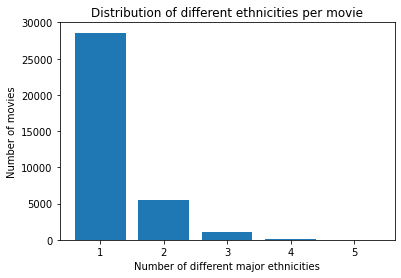

In [172]:
def plot_different_ethnicities_per_movie(characters):
    ethnicity_characters = characters.dropna(subset=['major_ethnicity'])
    num_different_ethnicities = ethnicity_characters.groupby(by=['freebase_movie_id'])['major_ethnicity'].nunique()
    num_ethnicies, count = np.unique(num_different_ethnicities, return_counts=True)
    plt.bar(num_ethnicies, count)
    plt.xlabel('Number of different major ethnicities')
    plt.ylabel('Number of movies')
    plt.title('Distribution of different ethnicities per movie')
plot_different_ethnicities_per_movie(characters)

Since now, we have been working using all the characters in the dataset, even if the same actor played more than one. Now, let's focus on actors instead of characters to figure out the success associated to the professional. First we create an actors dataset. We also compute in how many films in the dataset the actor appears, this value can be found in the column `num_movies`

In [173]:
actors = characters[['freebase_actor_id', 'freebase_movie_id', 'actor_name', 'actor_gender', 'actor_height_meters', 'ethnicity_label', 'major_ethnicity']]
actors = actors.dropna(subset=['freebase_actor_id'])
actors['num_movies'] = actors.groupby(by=['freebase_actor_id'])['freebase_actor_id'].transform('size')
actors.drop('freebase_movie_id', axis=1, inplace=True)
actors.drop_duplicates(subset=['freebase_actor_id'], inplace=True)
actors.head(5)

,freebase_actor_id,actor_name,actor_gender,actor_height_meters,ethnicity_label,major_ethnicity,num_movies
0,/m/03wcfv7,Wanda De Jesus,F,1.620,NaN,NaN,8
1,/m/0346l4,Natasha Henstridge,F,1.780,unknown,NaN,23
2,/m/01vw26l,Ice Cube,M,1.727,African Americans,Black,33
3,/m/034hyc,Jason Statham,M,1.750,NaN,NaN,31
4,/m/01y9xg,Clea DuVall,F,1.650,NaN,NaN,31


Again, let's split actors in genders

In [174]:
actors_male = actors[actors['actor_gender'] == 'M']
actors_female = actors[actors['actor_gender'] == 'F']

And now we can focus on the actors that have appeared in a greater number of movies. We fix this threshold at 15 movies.

In [175]:
def get_most_demanded_actors(actors, min_num_movies):
    return actors[actors['num_movies'] >= min_num_movies]

MIN_NUM_MOVIES_DEMANDED_ACTOR = 15
demanded_actors_male = get_most_demanded_actors(actors_male, MIN_NUM_MOVIES_DEMANDED_ACTOR)
demanded_actors_female = get_most_demanded_actors(actors_female, MIN_NUM_MOVIES_DEMANDED_ACTOR)


This way, we can compare if the most characteristic features of each actor are the same for the whole dataset of characters. We are plotting again the height distribution both for males and females.

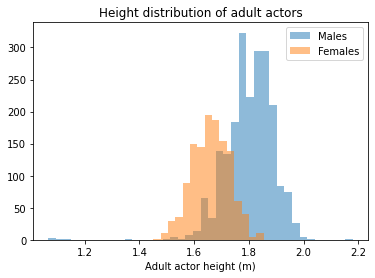

In [176]:
characters_height_histogram(demanded_actors_male, 40)
characters_height_histogram(demanded_actors_female, 15)

Also, the ethnicities are plotted again. We can observe that discriminations are even bigger.

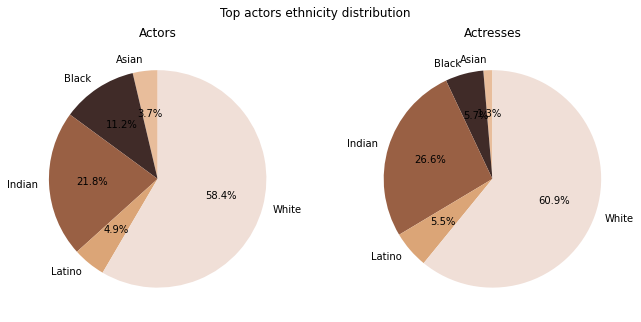

In [177]:
two_pie_charts_actor_ethnicities(demanded_actors_male, 
                                 demanded_actors_female, 
                                 title='Top actors ethnicity distribution', 
                                 title1='Actors', 
                                 title2='Actresses')

All these data about characters is going to be merged and analysed for the last milestone. By now, we have demonstrated that we have data enough to work and answer the proper questions

## What genres are the most profitable?

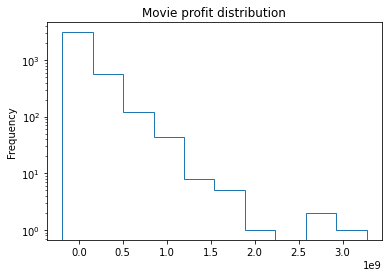

In [178]:
df_all['profit_modified'].plot(kind='hist', logy=True, histtype='step', title='Movie profit distribution');

In [179]:
df_all['genre1'] = df_all['genre'].apply(lambda el: el[0])

In [180]:
genres = df_all['genre1'].value_counts()

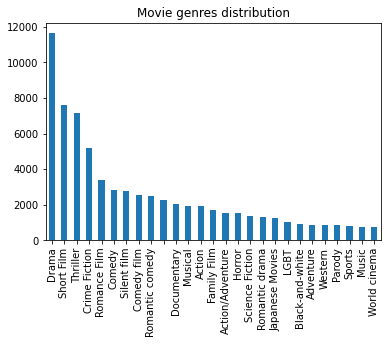

In [181]:
genres[genres > 700].plot(kind='bar', title='Movie genres distribution');

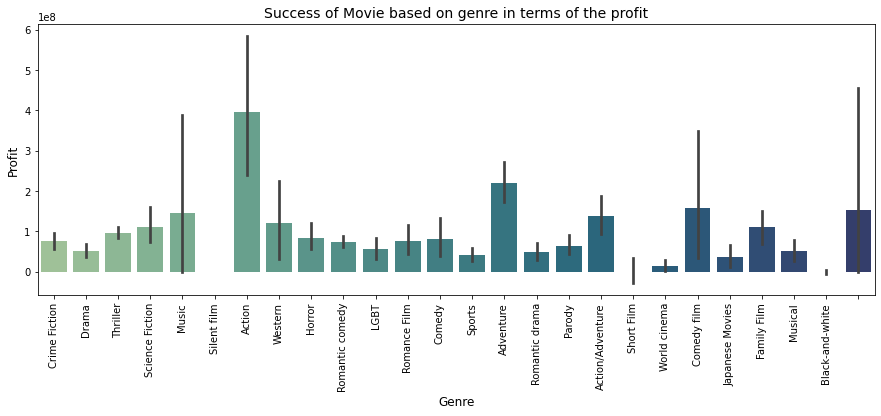

In [182]:
plt.figure(figsize=(15,5));
ax = sns.barplot(
    x="genre1",
    y="profit_modified",
    data=df_all[df_all['profit_modified'].notna() & df_all['genre1'].isin(genres[genres > 700].index.to_list())],
    palette='crest'
)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Profit', fontsize=12)
plt.title('Success of Movie based on genre in terms of the profit', fontsize=14)
_ = plt.xticks(rotation=90)

## correlation between the choice of topics and movie profitability can be investigated

In [183]:
df_all['genre1_category'] = df_all['genre1'].astype('category').cat.codes

C:\Users\34683\AppData\Local\Temp/ipykernel_25696/3979341198.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


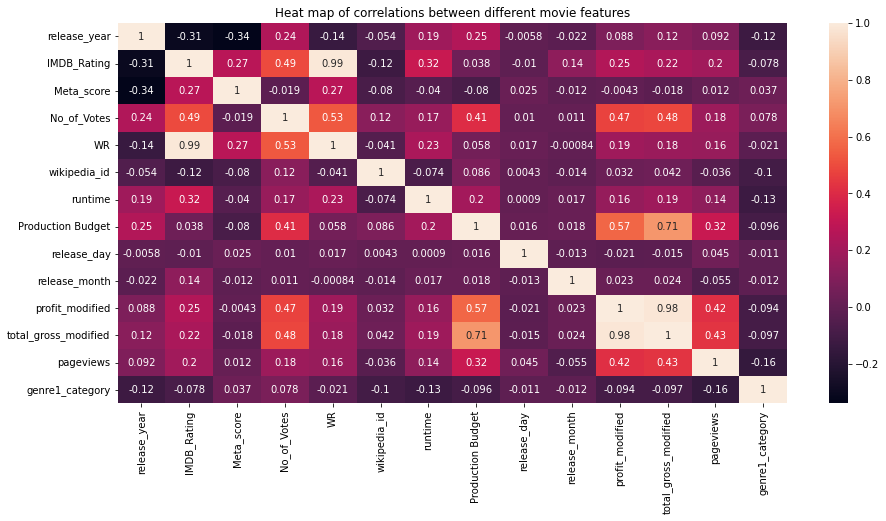

In [184]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

## Clustering between movies: Classics VS forgettable : check with wikipedia ID how much it is visited : time series of access 

In [185]:
wikipedia_pageviews.sample(5)

,name,date,pageviews
181234,The Twilight Saga: Eclipse,2018-04-28,1001
815744,Beverly Hills Cop II,2015-08-27,357
481523,Madagascar,2017-03-17,5596
711993,Hannibal,2020-05-06,3074
1698658,Zero Dark Thirty,2016-04-12,2400


<AxesSubplot:title={'center':'Pageviews for Spy Kids'}, xlabel='date'>

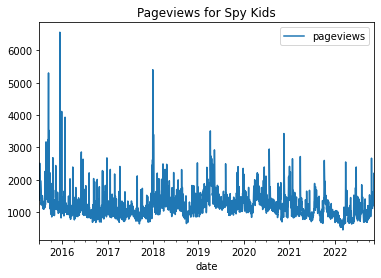

In [186]:
wikipedia_pageviews[wikipedia_pageviews['name'] == 'Spy Kids'].plot(x='date', y='pageviews', title='Pageviews for Spy Kids')

<AxesSubplot:title={'center':'Pageviews for Avengers: Endgame'}, xlabel='date'>

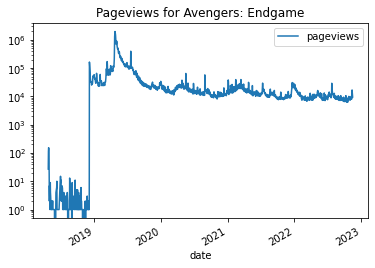

In [187]:
wikipedia_pageviews[wikipedia_pageviews['name'] == 'Avengers: Endgame'].plot(x='date', y='pageviews', logy=True, title='Pageviews for Avengers: Endgame')

In [188]:
df_all.sample(5)

,name,release_year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,...,countries,Production Budget,genre,release_day,release_month,profit_modified,total_gross_modified,pageviews,genre1,genre1_category
58227,WWII in HD,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,[War film],<NA>,<NA>,NaN,NaN,NaN,War film,292
2200,Go Figure,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[United States of America],NaN,"[Family Film, Drama, Comedy]",10,6,NaN,NaN,NaN,Family Film,119
50134,Star Trek Nemesis,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[United States of America],NaN,"[Crime Fiction, Thriller, Science Fiction, Adv...",9,12,NaN,NaN,NaN,Crime Fiction,80
49900,Skyway,1933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[United States of America],NaN,"[Comedy film, Drama]",30,8,NaN,NaN,NaN,Comedy film,62
4438,Project A,1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[Hong Kong],NaN,"[World cinema, Action/Adventure, Martial Arts ...",<NA>,<NA>,NaN,NaN,NaN,World cinema,298


In [189]:
df_all.columns

Index(['name', 'release_year', 'Certificate', 'IMDB_Rating', 'Overview',
       'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4',
       'No_of_Votes', 'WR', 'wikipedia_id', 'freebase_id', 'runtime',
       'languages', 'countries', 'Production Budget', 'genre', 'release_day',
       'release_month', 'profit_modified', 'total_gross_modified', 'pageviews',
       'genre1', 'genre1_category'],
      dtype='object')

In [353]:
mod = smf.ols(formula='pageviews ~ runtime + Certificate + IMDB_Rating + No_of_Votes + total_gross_modified + profit_modified + genre1', data=df_all[df_all['release_year'] < (2015-15)])
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pageviews   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                 -0.341
Method:                 Least Squares   F-statistic:                    0.5519
Date:                Fri, 18 Nov 2022   Prob (F-statistic):              0.957
Time:                        20:25:03   Log-Likelihood:                -604.28
No. Observations:                  68   AIC:                             1287.
Df Residuals:                      29   BIC:                             1373.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                              2.798e+04   2.17e+04      1.290      0.207   -1.64e+04    7.23e+04
Certificate[T.Approved]                  -0.0350      0.028     -1.265      0.216      -0.091       0.022
Certificate[T.G]                        329.6195   2337.930      0.141      0.889   -4451.985    5111.224
Certificate[T.GP]                        -0.0032      0.002     -1.284      0.209      -0.008       0.002
Certificate[T.M/PG]                      -0.0081      0.008     -0.976      0.337      -0.025       0.009
Certificate[T.NC-17]                  -3.509e-06      0.000     -0.020      0.984      -0.000       0.000
Certificate[T.Not Rated]                 -0.0150      0.011     -1.323      0.196      -0.038       0.008
Certificate[T.PG]                      -473.5705   4224.958     -0.112      0.912   -9114.580    8167.439
Certificate[T.PG-13]                    119.6331   3529.458      0.034      0.973   -7098.920    7338.186
Certificate[T.Passed]                   786.0776   1555.578      0.505      0.617   -2395.437    3967.593
Certificate[T.R]                         26.4235   2235.719      0.012      0.991   -4546.136    4598.983
Certificate[T.TV-PG]                     -0.0270      0.021     -1.273      0.213      -0.070       0.016
Certificate[T.U]                       -268.7969   1305.403     -0.206      0.838   -2938.646    2401.053
Certificate[T.UA]                       625.3911   1913.410      0.327      0.746   -3287.972    4538.754
Certificate[T.Unrated]                   -0.0064      0.006     -1.129      0.268      -0.018       0.005
genre1[T.A]                              -0.0004      0.003     -0.135      0.893      -0.007       0.006
genre1[T.Absurdism]                   -8.194e-12   7.04e-12     -1.165      0.254   -2.26e-11    6.19e-12
genre1[T.Action]                       1645.8686   3105.705      0.530      0.600   -4706.012    7997.749
genre1[T.Action Comedy]                 9.08e-13   2.37e-12      0.382      0.705   -3.95e-12    5.77e-12
genre1[T.Action Thrillers]            -4.925e-12   3.99e-12     -1.235      0.227   -1.31e-11    3.23e-12
genre1[T.Action/Adventure]             1.332e-12   4.62e-12      0.288      0.775   -8.12e-12    1.08e-11
genre1[T.Addiction Drama]              7.095e-12   9.02e-12      0.786      0.438   -1.14e-11    2.56e-11
genre1[T.Adult]                       -2.102e-13   9.58e-13     -0.219      0.828   -2.17e-12    1.75e-12
genre1[T.Adventure]                     442.0514   1588.393      0.278      0.783   -2806.578    3690.681
genre1[T.Adventure Comedy]              6.75e-12   9.17e-12      0.736      0.468    -1.2e-11    2.55e-11
genre1[T.Airplanes and airports]      -4.177e-13   1.61e-12     -0.259      0.797   -3.71e-12    2.88e-12
genre1[T.